❌ File not found for HCHO_TROP


/var/folders/91/tmzh46hs1_vghy7y94yp_4_w0000gn/T/ipykernel_85446/3264646740.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[0] = pd.to_datetime(df[0], errors='coerce')


HCHO_TOTAL: ✅ 69147 valid rows | Flags: [12.0, 11.0, 10.0]
❌ File not found for NO2_TROP


/var/folders/91/tmzh46hs1_vghy7y94yp_4_w0000gn/T/ipykernel_85446/3264646740.py:54: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[0] = pd.to_datetime(df[0], errors='coerce')


NO2_TOTAL: ✅ 529607 valid rows | Flags: [12.0, 11.0, 10.0]
❌ File not found for O3
❌ File not found for SO2
❌ File not found for H2O


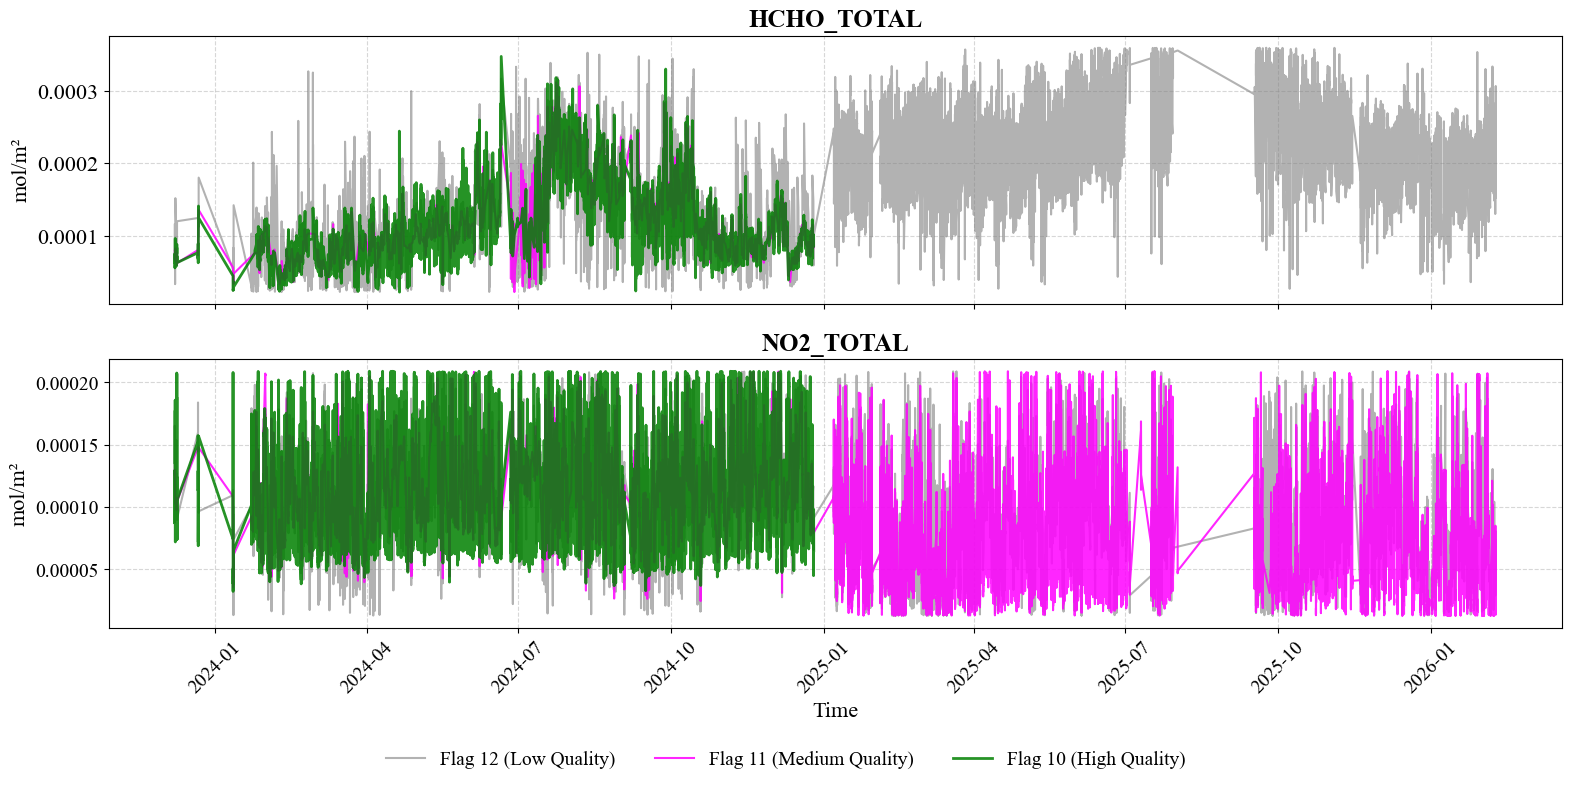

✅ Saved: Data/TimeSeries_Plots/All_Gases_TimeSeries_SingleLegend.png


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Setup paths ---
data_dir = r'Data'
output_dir = os.path.join(data_dir, 'TimeSeries_Plots')
os.makedirs(output_dir, exist_ok=True)

# --- Gas-specific column indices ---
gas_configs = {
    'HCHO_TROP':  {'file_tag': 'rfuh', 'flag_col': 41, 'value_col': 48},
    'HCHO_TOTAL': {'file_tag': 'rfus', 'flag_col': 35, 'value_col': 38},
    'NO2_TROP':   {'file_tag': 'rnvh', 'flag_col': 52, 'value_col': 61},
    'NO2_TOTAL':  {'file_tag': 'rnvs', 'flag_col': 32, 'value_col': 38},
    'O3':         {'file_tag': 'rout', 'flag_col': 35, 'value_col': 38},
    'SO2':        {'file_tag': 'rsus', 'flag_col': 32, 'value_col': 39},
    'H2O':        {'file_tag': 'rwvt', 'flag_col': 32, 'value_col': 39},
}

# --- Colors and labels for flags ---
flag_colors = {
    10.0: 'green',
    11.0: 'magenta',
    12.0: 'gray'
}

flag_labels = {
    10.0: 'Flag 10 (High Quality)',
    11.0: 'Flag 11 (Medium Quality)',
    12.0: 'Flag 12 (Low Quality)'
}

# --- Read and parse Pandora file ---
def read_file(file_path, flag_col, value_col):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
    except:
        with open(file_path, 'r', encoding='ISO-8859-1') as f:
            lines = f.readlines()

    data_start = next(i for i, line in enumerate(lines) if line.startswith('---')) + 1
    data_lines = [
        line.strip().split() for line in lines[data_start:]
        if line.strip() and len(line.split()) > max(flag_col, value_col)
    ]

    df = pd.DataFrame(data_lines)
    if df.empty:
        return pd.DataFrame()

    df[0] = pd.to_datetime(df[0], errors='coerce')
    df[flag_col] = pd.to_numeric(df[flag_col], errors='coerce')
    df[value_col] = pd.to_numeric(df[value_col], errors='coerce')

    df = df.rename(columns={0: 'time', flag_col: 'Flag', value_col: 'Value'})
    df = df[df['Flag'].isin([10.0, 11.0, 12.0])]
    df = df[['time', 'Flag', 'Value']].dropna()

    # --- Remove top/bottom 1% outliers ---
    lower = df['Value'].quantile(0.01)
    upper = df['Value'].quantile(0.99)
    df = df[(df['Value'] >= lower) & (df['Value'] <= upper)]

    return df

# --- Load and filter all gas files ---
all_data = {}
for gas_name, config in gas_configs.items():
    tag = config['file_tag']
    files = [f for f in os.listdir(data_dir) if tag in f and f.endswith('.txt')]
    if not files:
        print(f"❌ File not found for {gas_name}")
        continue

    file_path = os.path.join(data_dir, files[0])
    df = read_file(file_path, config['flag_col'], config['value_col'])
    if not df.empty:
        print(f"{gas_name}: ✅ {len(df)} valid rows | Flags: {df['Flag'].unique().tolist()}")
        all_data[gas_name] = df
    else:
        print(f"⚠️ No valid data for {gas_name}")

# --- Plot all gases with a single external legend ---
if not all_data:
    print("🚫 No valid data found for any gas.")
else:
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': 'Times New Roman',
        'font.size': 16
    })

    n = len(all_data)
    fig, axes = plt.subplots(nrows=n, figsize=(16, 4 * n), sharex=True)
    if n == 1:
        axes = [axes]

    flag_priority = [12.0, 11.0, 10.0]
    added_flags = set()
    handles = []
    labels = []

    for ax, (gas_name, df) in zip(axes, all_data.items()):
        xmax = df['time'].max()
        for flag in flag_priority:
            group = df[df['Flag'] == flag]
            if group.empty:
                continue
            line, = ax.plot(group['time'], group['Value'],
                            color=flag_colors.get(flag, 'black'),
                            linewidth=2 if flag == 10.0 else 1.5,
                            alpha=0.6 if flag == 12.0 else 0.85)
            # Add legend handle only once
            if flag not in added_flags:
                handles.append(line)
                labels.append(flag_labels[flag])
                added_flags.add(flag)

        ax.set_title(gas_name, fontsize=18, weight='bold')
        ax.set_ylabel("mol/m²", fontsize=16)
        ax.grid(True, linestyle='--', alpha=0.5)

    axes[-1].set_xlabel("Time", fontsize=16)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # space for legend

    # --- External single legend ---
    fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=14, frameon=False)

    save_path = os.path.join(output_dir, "All_Gases_TimeSeries_SingleLegend.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved: {save_path}")
